## Instalando o ambiente necessário

In [0]:
#@title Instala os pacotes necessários {display-mode: "form"}

!pip install powerlaw 
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
!apt-get update
#!apt-get remove msodbcsql17
#!apt autoremove
!ACCEPT_EULA=Y apt-get install msodbcsql17
!lsb_release -a
!sudo apt-get install unixodbc-dev
!pip install pyodbc



## Importações e configurações gerais

In [0]:
# @title Importações {display-mode: "form"}

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.dates as mdates

from datetime import datetime
import datetime
from datetime import timedelta

import random

from mlxtend.plotting import ecdf
import powerlaw

from sklearn import metrics
import itertools


In [0]:
#@title cria as funções auxiliares {display-mode: "form"}

def setSeabornStyle(style='Default'):
    if (style == 'Dark'):
        #sns.set(style="ticks", palette='dark')
        sns.set(style="ticks")
        sns.set_palette(sns.xkcd_palette(["windows blue"])+sns.color_palette('Set2', 4)+sns.xkcd_palette(["amber", "greyish", "faded green", "dusty purple"]))
    else:
        #sns.set(style="ticks", palette='Pastel1')
        sns.set(style="ticks")
        sns.set_palette(sns.color_palette(["#A576B6", "#58A7DC"])+sns.color_palette('Set2', 8))

def fitDistribution(x1, x_min=None):
    if (x_min != None):
        fit = powerlaw.Fit(np.array(x1), discrete=True, xmin=x_min)
    else:
        fit = powerlaw.Fit(np.array(x1), discrete=True)
    fit.power_law.alpha
    fit.power_law.sigma

    #para ver as distribuições possíveis
    #fit.supported_distributions
    distributions = ['exponential','lognormal','lognormal_positive','stretched_exponential','truncated_power_law']


    for dist in distributions:
        t = fit.distribution_compare('power_law', dist, normalized_ratio=True)
        print("({2}, {0:12.12f}, {1:12.12f})".format(t[0], t[1], dist))
        
    return fit;

    

In [0]:
# @title configura variaveis do ambiente {display-mode: "form"}


#import sys
#print(sys.version)

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:20,.2f}'.format

np.set_printoptions(suppress=True)



contrastColorPallete = ['#998ec3', '#f1a340', '#f7f7f7']
paleta = sns.color_palette("Pastel1", 20)
setSeabornStyle()

size_p = 4
size_g = 8
size_xg = 12
size_xxg = 16

line_size=0.4

pd.set_option('display.max_columns', 500)

%load_ext google.colab.data_table


## Acesso ao banco de dados

In [0]:
# @title Conexão com o banco {display-mode: "form"}

import pyodbc
import json


with open('/content/drive/My Drive/Colab Notebooks/sql_credentials.json') as f:
    data = json.load(f)
    username = data['userName']
    password = data['userPassword']
    server = data['server']
    database = "db_strava"


driver= '{ODBC Driver 17 for SQL Server}'
conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
    


In [0]:
# @title Consulta ao banco {display-mode: "form"}


query = """
select (select count(*)
        from community_membership c where c.community = ac.community and c.algorithm = ac.algorithm
        group by community, algorithm) as size,
       algorithm, community
from answer_community ac
"""

df = pd.read_sql(query, conn)



Text(0.5, 1.0, 'distribuição das respostas por comunidade')

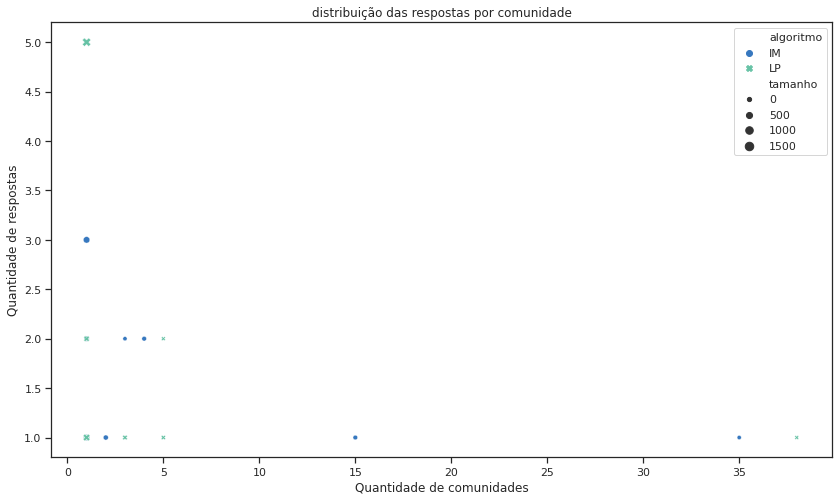

In [16]:
# @title Gera o gráfico {display-mode: "form"}

setSeabornStyle('Dark')
plt.figure(figsize=(14,8))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)

#plt.subplot(1,1,1)


df['answers'] = 0
df['size'] = (df['size']/100).astype(int)
df['size'] = (df['size'] * 100).astype(int)
df = df.groupby(['community','size', 'algorithm'], as_index = False).count()
#arredonda por centenas
#t['size'] = t['size']/100
df = df.groupby(['answers','size', 'algorithm'], as_index = False).count()
df.rename(inplace=True, columns={"size": "tamanho"})
df.rename(inplace=True, columns={"answers": "respostas"})
df.rename(inplace=True, columns={"community": "comunidades"})
df.rename(inplace=True, columns={"algorithm": "algoritmo"})


g = sns.scatterplot(x="comunidades", y="respostas", hue="algoritmo", style="algoritmo", size='tamanho', data=df, linewidth=line_size)
#g.set(yscale='log')
#g.set(xscale='log')
g.set_ylabel('Quantidade de respostas')
g.set_xlabel('Quantidade de comunidades')


plt.title('distribuição das respostas por comunidade')

#t = None

### Comunidades com pelo menos 3 respostas

In [17]:
# @title Quantas {display-mode: "form"}


df[df['respostas'] > 2].groupby(['algoritmo', 'respostas'], as_index = False).count().rename(inplace=False, columns={"tamanho": "quantidade"})


,algoritmo,respostas,quantidade,comunidades
0,IM,3,3,3
1,IM,5,1,1
2,LP,3,2,2
3,LP,5,2,2


In [18]:
# @title Quais {display-mode: "form"}


df = pd.read_sql(query, conn)
df['qtd'] = 0
df = df.groupby(['size', 'algorithm', 'community'], as_index = False).count()
df[df['qtd'] > 2]

,size,algorithm,community,qtd
22,17,LP,35,3
93,157,IM,123,5
107,196,LP,34,5
117,341,IM,23,3
118,396,LP,728,3
122,588,IM,5,3
124,653,IM,3,3
126,1467,LP,242,5
